In [149]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as preprocessing
le= preprocessing.LabelEncoder()

#download
import urllib.request as req
import zipfile
import io


# Downloading

In [150]:
url = 'https://github.com/ecodan/school-shooting-data/archive/refs/heads/master.zip'
fin = req.urlopen(url)

with zipfile.ZipFile(io.BytesIO(fin.read())) as z:
    print(z.namelist())
    raw_data_2 = pd.read_csv(z.open('school-shooting-data-master/cps_01_formatted.csv'))
    raw_data_1 = pd.read_csv(z.open('school-shooting-data-master/pah_wikp_combo.csv'))

print(raw_data_2.head())
print('----------------------------')
raw_data_1

['school-shooting-data-master/', 'school-shooting-data-master/README.md', 'school-shooting-data-master/cps_01_formatted.csv', 'school-shooting-data-master/datapackage.json', 'school-shooting-data-master/pah_wikp_combo.csv']
   Year  Total enrolled  N-Total  N-Public  N-Private  K-Total  K-Public  \
0  2022           72346   3405.0    1888.0     1517.0     3696      3009   
1  2021           73456   3801.0    2134.0     1667.0     3765      3145   
2  2020           73222   3545.0    2094.0     1451.0     3698      3112   
3  2019           76089   4728.0    2614.0     2114.0     4057      3531   
4  2018           76840   4836.0    2763.0     2073.0     3908      3529   

   K-Private  E-Total  E-Public  E-Private  H-Total  H-Public  H-Private  \
0        687    32005     28300       3705    15957   14747.0     1211.0   
1        619    32148     28708       3439    16195   14992.0     1203.0   
2        586    32046     28596       3449    16259   14964.0     1296.0   
3        525   

,Date,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc,Unnamed: 10,Unnamed: 11
0,3/27/1990,Brooklyn,New York,NaN,C,0,1.0,NaN,Wikp,A black youth was taunted with racial slurs by...,NaN,NaN
1,5/20/1990,Centerville,Tennessee,suburban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN
2,8/26/1990,Las Vegas,Nevada,urban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN
3,9/11/1990,San Antonio,Texas,NaN,HS,0,3.0,NaN,Wikp,3 students were wounded when gunfire broke out...,NaN,NaN
4,1/8/1991,Richardson,Texas,urban,HS,0,NaN,NaN,Pah,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
749,9/3/2022,Dover,Delaware,NaN,C,0,4.0,NaN,NaN,A non-student shot four people near basketball...,NaN,NaN
750,9/24/2022,Richfield,Minnesota,NaN,HS,0,2.0,NaN,NaN,Two people were shot following a fight near a ...,NaN,NaN
751,9/27/2022,Philadelphia,Pennsylvania,NaN,HS,1,4.0,NaN,NaN,Following a football scrimmage at Roxborough H...,NaN,NaN
752,9/28/2022,Oakland,California,NaN,HS,0,4.0,NaN,NaN,Six adults were wounded in a shooting at a Rud...,NaN,NaN


# Exploring

In [151]:
raw_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         754 non-null    object 
 1   City         754 non-null    object 
 2   State        754 non-null    object 
 3   AreaType     381 non-null    object 
 4   School       752 non-null    object 
 5   Fatalities   754 non-null    int64  
 6   Wounded      373 non-null    float64
 7   Dupe         138 non-null    object 
 8   Source       707 non-null    object 
 9   Desc         371 non-null    object 
 10  Unnamed: 10  0 non-null      float64
 11  Unnamed: 11  0 non-null      float64
dtypes: float64(3), int64(1), object(8)
memory usage: 70.8+ KB


#Cleaning

In [152]:
df=raw_data_1.copy()

In [153]:
#colum_names
def clean_column_names(df):
    '''
    function to call on after DataFrame is created to format column names in lowercase 
    without spaces before querying.
    
    :param query: DataFrame
    :returns: DataFrame with columns formatted  
    '''
    import pandas as pd 
    
    columns=df.columns
    new_names=[]
    char_dict={' ':'_',':':''}
    for c in columns:
        new_names.append(c
            .lower()
            .translate(char_dict)
          )
    df.columns=new_names

    return df

df=clean_column_names(df)
df.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         754 non-null    object 
 1   city         754 non-null    object 
 2   state        754 non-null    object 
 3   areatype     381 non-null    object 
 4   school       752 non-null    object 
 5   fatalities   754 non-null    int64  
 6   wounded      373 non-null    float64
 7   dupe         138 non-null    object 
 8   source       707 non-null    object 
 9   desc         371 non-null    object 
 10  unnamed: 10  0 non-null      float64
 11  unnamed: 11  0 non-null      float64
dtypes: float64(3), int64(1), object(8)
memory usage: 70.8+ KB


In [154]:
#date to timestamp
df.date=pd.to_datetime(df.date)

In [155]:
#school: delete '-" value
df.school=df.school.replace({'-':np.nan})

In [156]:
#state
value_dict={'District Of Columbia':'D.C.', 'District of Columbia':'D.C.', 'IA':'Iowa'}
df.state=df.state.replace(value_dict)

In [157]:
#add calculations
df=(df
  .assign(year=df.date.dt.year, month=df.date.dt.month)
  .assign(decade=((df.date.dt.year // 10) * 10))
)
df

,date,city,state,areatype,school,fatalities,wounded,dupe,source,desc,unnamed: 10,unnamed: 11,year,month,decade
0,1990-03-27,Brooklyn,New York,NaN,C,0,1.0,NaN,Wikp,A black youth was taunted with racial slurs by...,NaN,NaN,1990,3,1990
1,1990-05-20,Centerville,Tennessee,suburban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN,1990,5,1990
2,1990-08-26,Las Vegas,Nevada,urban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN,1990,8,1990
3,1990-09-11,San Antonio,Texas,NaN,HS,0,3.0,NaN,Wikp,3 students were wounded when gunfire broke out...,NaN,NaN,1990,9,1990
4,1991-01-08,Richardson,Texas,urban,HS,0,NaN,NaN,Pah,NaN,NaN,NaN,1991,1,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,2022-09-03,Dover,Delaware,NaN,C,0,4.0,NaN,NaN,A non-student shot four people near basketball...,NaN,NaN,2022,9,2020
750,2022-09-24,Richfield,Minnesota,NaN,HS,0,2.0,NaN,NaN,Two people were shot following a fight near a ...,NaN,NaN,2022,9,2020
751,2022-09-27,Philadelphia,Pennsylvania,NaN,HS,1,4.0,NaN,NaN,Following a football scrimmage at Roxborough H...,NaN,NaN,2022,9,2020
752,2022-09-28,Oakland,California,NaN,HS,0,4.0,NaN,NaN,Six adults were wounded in a shooting at a Rud...,NaN,NaN,2022,9,2020


# Styling

In [158]:
# Color blind friendly colors

# Colorblind-friendly colors
colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]

style.use('fivethirtyeight')
# sns.axes_style({
#     'axes.facecolor': 'white',
#     'axes.edgecolor': 'black',
#     'axes.grid': False,
#     'figure.facecolor': 'white',
#     'grid.color': 'white',
#     'grid.linestyle': '-',
#     'font.sans-serif': 'Arial',
#     'grid.color': '#ffffff'

# })

footer_left="AAAS24 GIthub -  School Schootings" 
footer_right="Source: Pah/Amaral/Hagan Research & Wikipedia"

#Homework

## Incidents per Year

In [159]:



x_var='rol_decade'
bins=list(range(df.year.max()-30,df.year.max()+1,10))
print(bins)
data=(
  df.copy()
  .assign(rol_decade=pd.cut(x=df.year,bins=bins, labels=[ '1992-2001', '2002-2011','2012-2022']))
  .groupby([x_var])
  .agg({'date': "count", 'fatalities':"sum", "wounded":"sum" } )
  .assign(total_victims= lambda _df: _df.wounded + _df.fatalities)
  .rename(columns={"date":"count_shootings"})
  .drop(['fatalities', 'wounded'], axis=1)
  .reset_index()
)
data 

[1992, 2002, 2012, 2022]


,rol_decade,count_shootings,total_victims
0,1992-2001,227,426.0
1,2002-2011,247,471.0
2,2012-2022,244,603.0


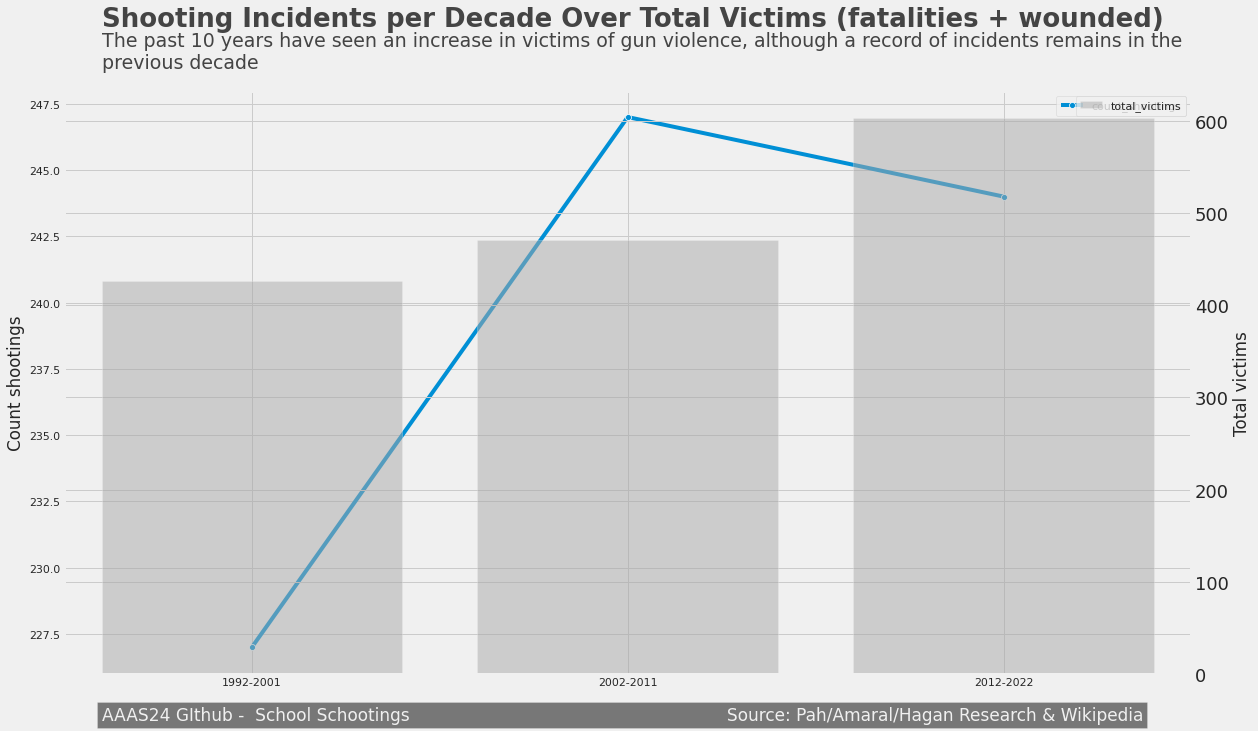

In [160]:
#incidents per year
title='Shooting Incidents per Decade Over Total Victims (fatalities + wounded)'
subtitle='The past 10 years have seen an increase in victims of gun violence, although a record of incidents remains in the \nprevious decade'
x_var='rol_decade'
num_blank=30 #modify to make footer fit 

#data

bins=list(range(df.year.max()-30,df.year.max()+1,10))
data=(
  df.copy()
  .assign(rol_decade=pd.cut(x=df.year,bins=bins, labels=[ '1992-2001', '2002-2011','2012-2022']))
  .groupby([x_var])
  .agg({'date': "count", 'fatalities':"sum", "wounded":"sum" } )
  .assign(total_victims= lambda _df: _df.wounded + _df.fatalities)
  .rename(columns={"date":"count_shootings"})
  .drop(['fatalities', 'wounded'], axis=1)
  .reset_index()
)
data 

#
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(18,10))

##1st chart
y_var='count_shootings'
sns.lineplot(data = data.count_shootings, marker='o', sort = False, ax=ax1, label=y_var)
plt.ylabel(y_var.replace("_"," ").capitalize())
ax2 = ax1.twinx()

##2nd chart
y_var='total_victims'
sns.barplot(data = data, x=x_var, y=y_var, alpha=0.5, ax=ax2, color='#a9a9a9', label=y_var)
plt.ylabel(y_var.replace("_"," ").capitalize())

##labels 
plt.axhline(y=0, alpha=0.7, linewidth=1.5, color='black')

##leyend
plt.legend(labelspacing=  2)

sns.set(rc={"figure.figsize":(20 ,8)})

##styling
style.use('fivethirtyeight')

#hiding x label
a=plt.gca()
xax = a.axes.get_xaxis()
xax = xax.set_visible(False)

###Title & Subtitle
plt.text(x=-0.4, y=data[y_var].max()+100, 
              s=title, 
              fontsize=26, weight='bold', alpha=.85
              )

plt.text(x=-0.4, y=data[y_var].max()+55, 
              s=subtitle, 
              fontsize=19, alpha=.85
              )

###Footnote Box
plt.tick_params(axis='both', which='major', labelsize=18)

num_spaces=" ".join(" "*int(num_blank))
plt.text(x=-0.4, y=-50, 
              s=footer_left+num_spaces+footer_right,
              fontsize=17,
              color="#f0f0f0",
              bbox=dict(facecolor="black", alpha=0.5)
              )



plt.show()



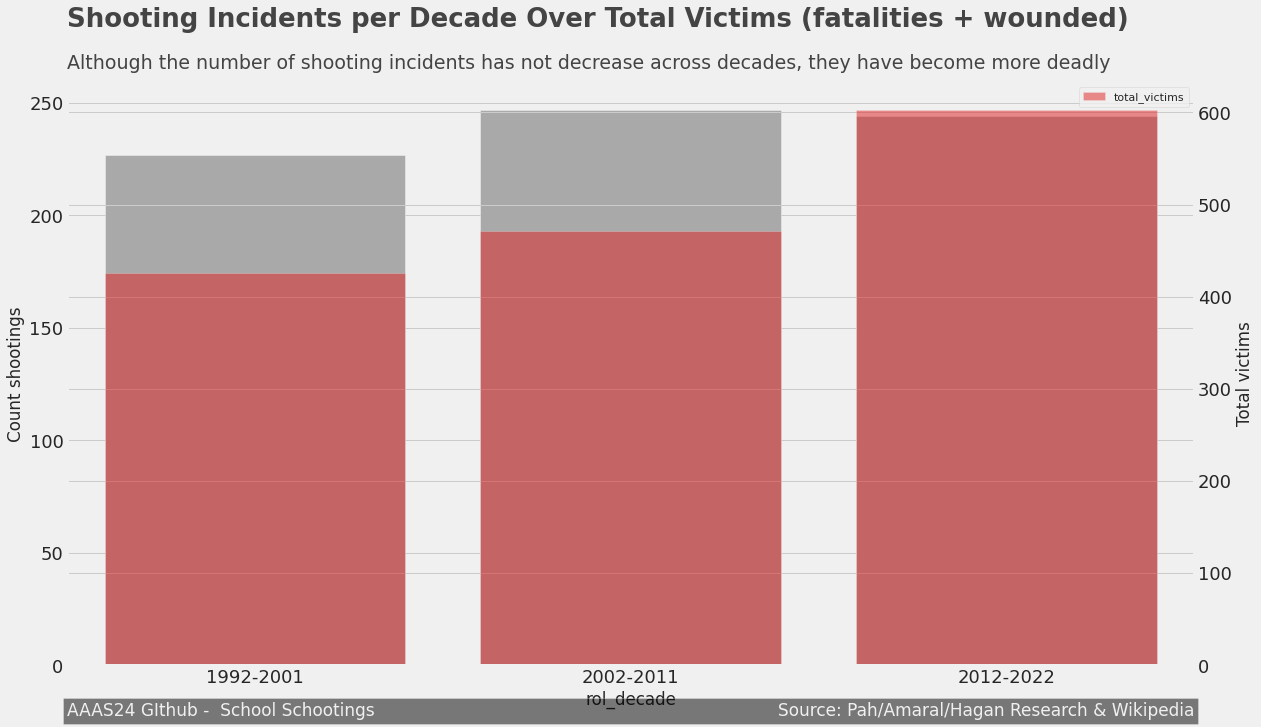

In [161]:
#incidents per year
title='Shooting Incidents per Decade Over Total Victims (fatalities + wounded)'
subtitle='Although the number of shooting incidents has not decrease across decades, they have become more deadly'
x_var='rol_decade'
text_x=38 #modify to make footer fit 

#data

bins=list(range(df.year.max()-30,df.year.max()+1,10))
data=(
  df.copy()
  .assign(rol_decade=pd.cut(x=df.year,bins=bins, labels=[ '1992-2001', '2002-2011','2012-2022']))
  .groupby([x_var])
  .agg({'date': "count", 'fatalities':"sum", "wounded":"sum" } )
  .assign(total_victims= lambda _df: _df.wounded + _df.fatalities)
  .rename(columns={"date":"count_shootings"})
  .drop(['fatalities', 'wounded'], axis=1)
  .reset_index()
)
data



ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(18,10))

##1st chart
y_var='count_shootings'
sns.barplot(data = data.loc[:,['rol_decade','count_shootings']], x=x_var, y=y_var, alpha=1, ax=ax1, color='#a9a9a9', label=y_var)
plt.ylabel(y_var.replace("_"," ").capitalize())
plt.tick_params(axis='both', which='major', labelsize=18)
ax2 = ax1.twinx()

##2nd chart
y_var='total_victims'
sns.barplot(data = data.loc[:,['rol_decade','total_victims']], x=x_var, y=y_var, alpha=0.5, ax=ax2, color='red', label=y_var)
plt.ylabel(y_var.replace("_"," ").capitalize())
plt.tick_params(axis='both', which='major', labelsize=18)

##labels 
plt.axhline(y=0, alpha=0.7, linewidth=1.5, color='black')
#hiding x label
a=plt.gca()
xax = a.axes.get_xaxis()
xax = xax.set_visible(False)

##leyend
plt.legend(labelspacing=  2)

##styling
style.use('fivethirtyeight')
sns.set_style("white")

###Title & Subtitle
plt.text(x=-0.5, y=data[y_var].max()+90, 
              s=title, 
              fontsize=26, weight='bold', alpha=.85
              )

plt.text(x=-0.5, y=data[y_var].max()+45, 
              s=subtitle, 
              fontsize=19, alpha=.85
              )

###Footnote Box
width_ticks=(text_x)
num_spaces=" ".join(" "*int(text_x))
plt.text(x=-0.5, y=-55, 
              s=footer_left+num_spaces+footer_right,
              fontsize=17,
              color="#f0f0f0",
              bbox=dict(facecolor="black", alpha=0.5)
              )



plt.show()


##Evaluating seasonality patterns

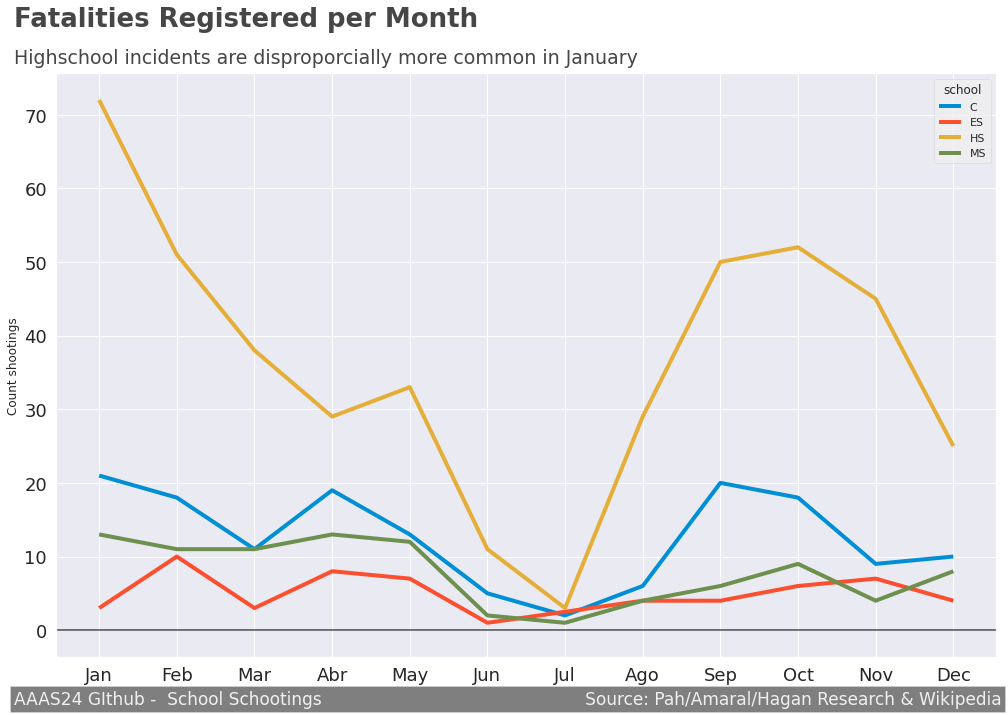

In [184]:
#fatalities per months
title='Fatalities Registered per Month'
subtitle='Highschool incidents are disproporcially more common in January'
x_var='month'
y_var='count_shootings'
text_x=25

#data
data=(
  df.copy()
  .groupby(['month', 'school'])
  .agg({'date': "count"} )
  .rename(columns={"date":"count_shootings"})
  .reset_index()
)
data 

#plot
##styling
sns.set(rc={"figure.figsize":(15 ,10)}) #(width,height)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.axhline(y=0, alpha=0.7, linewidth=1.5, color='black')
style.use('fivethirtyeight')
# sns.set_style("white")

##plot
ax=sns.lineplot(data=data, x=x_var, y=y_var, hue='school')


##labels 
plt.ylabel(y_var.replace("_"," ").capitalize())
plt.xticks(np.arange(1, 13, step=1),['Jan', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec'] )
#hiding x label
ax.set(xlabel=None)



x=0.1
###Title & Subtitle
plt.text(x=-x, y=data[y_var].max()+10, 
              s=title, 
              fontsize=26, weight='bold', alpha=.85
              )

plt.text(x=-x, y=data[y_var].max()+5, 
              s=subtitle, 
              fontsize=19, alpha=.85
              )

###Footnote Box
width_ticks=(text_x)
num_spaces=" ".join(" "*int(text_x))
plt.text(x=-x, y=-10, 
              s=footer_left+num_spaces+footer_right,
              fontsize=17,
              color="#f0f0f0",
              bbox=dict(facecolor="black", alpha=0.5)
              )



plt.show()

## Incidents per decade per school type

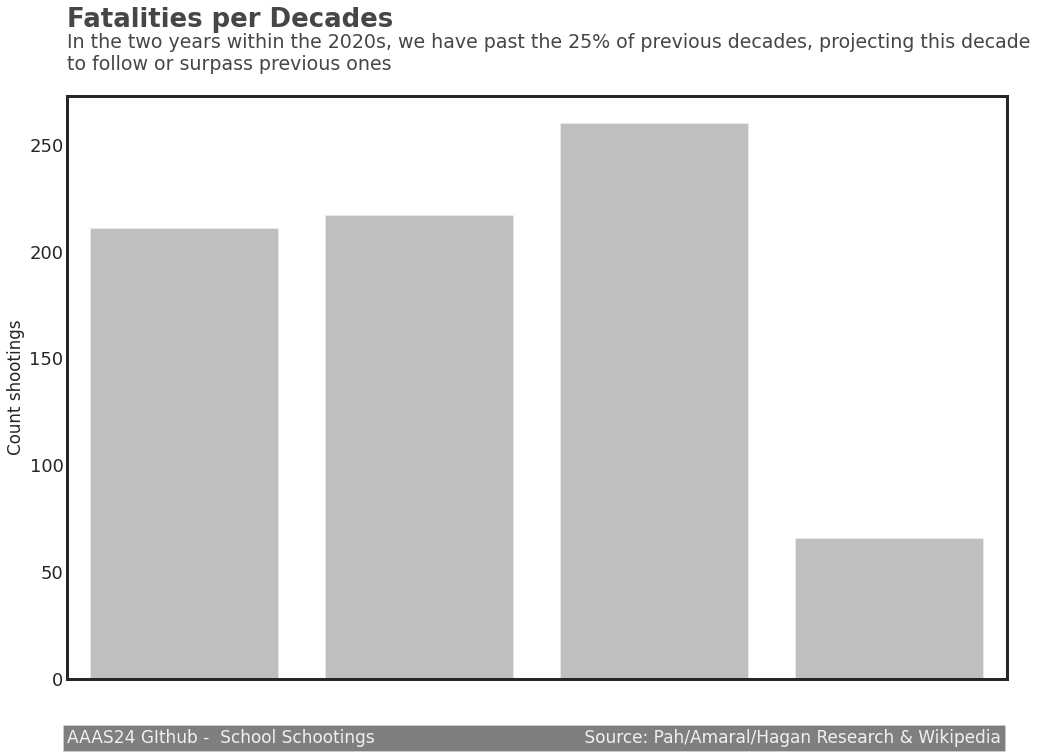

In [165]:
#Incidents per decades
title='Fatalities per Decades'
subtitle='In the two years within the 2020s, we have past the 25% of previous decades, projecting this decade \nto follow or surpass previous ones'
x_var='decade'
y_var='count_shootings'
text_x=20

#data
data=(
  df.copy()
  .groupby([x_var])
  .agg({'date': "count"} )
  .rename(columns={"date":"count_shootings"})
  .reset_index()
)
data 

#plot
sns.set_style("white")
sns.barplot(data=data, x=x_var, y=y_var, color='grey', alpha=0.5)
plt.ylabel(y_var.replace("_"," ").capitalize())
#hiding x label
a=plt.gca()
xax = a.axes.get_xaxis()
xax = xax.set_visible(False)

##style
sns.set(rc={"figure.figsize":(15 ,10)}) #(width,height)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.axhline(y=0, alpha=0.7, linewidth=1.5, color='black')
style.use('fivethirtyeight')

x=0.5
###Title & Subtitle
plt.text(x=-x, y=data[y_var].max()+45, 
              s=title, 
              fontsize=26, weight='bold', alpha=.85
              )

plt.text(x=-x, y=data[y_var].max()+25, 
              s=subtitle, 
              fontsize=19, alpha=.85
              )

###Footnote Box
width_ticks=(text_x)
num_spaces=" ".join(" "*int(text_x))
plt.text(x=-x, y=-30, 
              s=footer_left+num_spaces+footer_right,
              fontsize=17,
              color="#f0f0f0",
              bbox=dict(facecolor="black", alpha=0.5)
              )



plt.show()

In [ ]:
#Idea: Forcast decade

##Fatalities per School Type

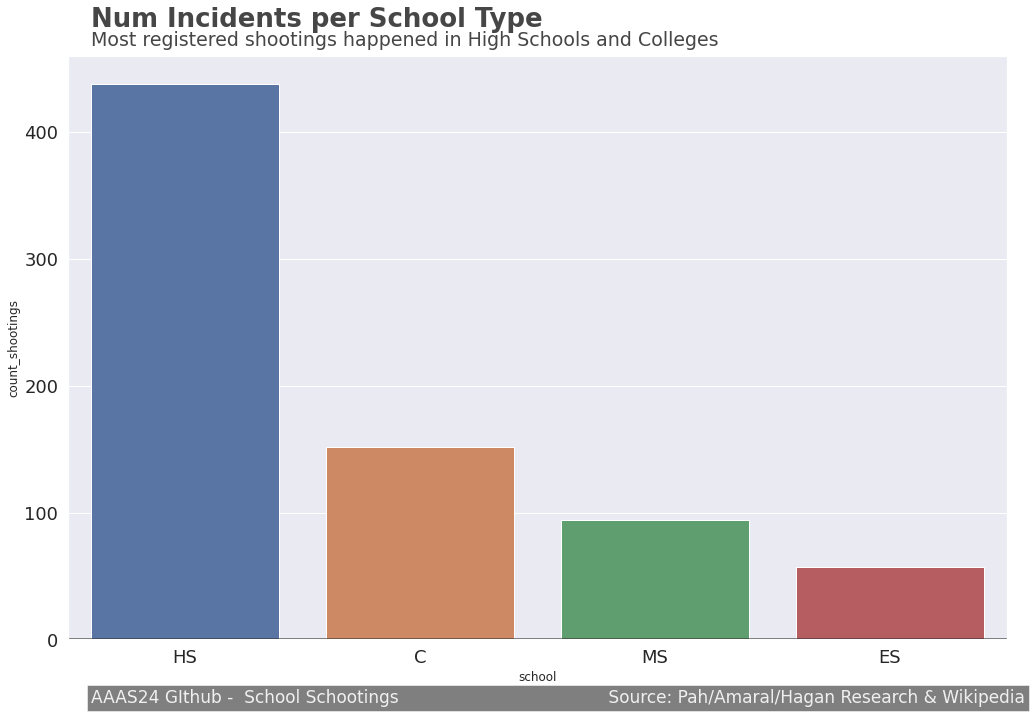

In [181]:
title='Num Incidents per School Type'
subtitle='Most registered shootings happened in High Schools and Colleges'
x_var='school'
y_var='count_shootings'

text_x=20


data=(
  df.copy()
  .groupby([x_var])
  .agg({'date': "count"} )
  .rename(columns={"date":"count_shootings"})
  .sort_values("count_shootings", ascending=False)
  .reset_index()
)
# data

sns.set(rc={"figure.figsize":(15 ,10)}) #(width,height)
sns.barplot(data=data, x=x_var, y=y_var)

#styling
plt.tick_params(axis='both', which='major', labelsize=18)
plt.axhline(y=0, alpha=0.7, linewidth=1.5, color='black')


##title & subtitle
x=-0.4
plt.text(x=x, y=data[y_var].max()+45, 
              s=title, 
              fontsize=26, weight='bold', alpha=.85
              )
plt.text(x=x, y=data[y_var].max()+30, 
              s=subtitle, 
              fontsize=19, alpha=.85
              )

##footer
num_spaces=" ".join(" "*int(text_x))
plt.text(x=x, y=-50, 
              s=footer_left+num_spaces+footer_right,
              fontsize=17, color="#f0f0f0",
              bbox=dict(facecolor="black", alpha=0.5)
              )
plt.show()

##Fatalities per Area Type

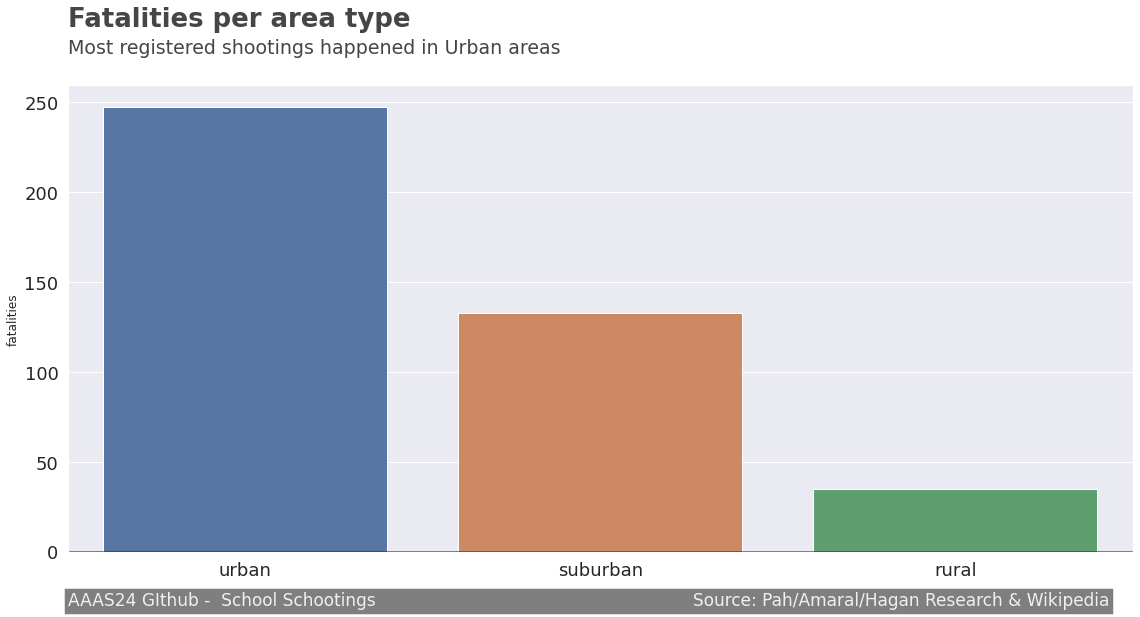

In [183]:
title='Fatalities per area type'
subtitle='Most registered shootings happened in Urban areas'
x_var='areatype'
y_var='fatalities'
text_x=30

data=(
    df.copy()
    .loc[:,[x_var,y_var]]
    .groupby([x_var]).sum()
    .sort_values(y_var, ascending=False)
    .reset_index()
)
data

ax=sns.barplot(data=data, x=x_var, y=y_var)
sns.set(rc={"figure.figsize":(17 ,8)}) #(width,height)

#styling
plt.tick_params(axis='both', which='major', labelsize=18)
plt.axhline(y=0, alpha=0.7, linewidth=1.5, color='black')

##hiding x label
ax.set(xlabel=None)



###Title & Subtitle
x=-0.5
plt.text(x=x, y=data[y_var].max()+45, 
              s=title, 
              fontsize=26, weight='bold', alpha=.85
              )
plt.text(x=x, y=data[y_var].max()+30, 
              s=subtitle, 
              fontsize=19, alpha=.85
              )

##Footer #1
num_spaces=" ".join(" "*int(text_x))
plt.text(x=x, y=-30, 
              s=footer_left+num_spaces+footer_right,
              fontsize=17, color="#f0f0f0",
              bbox=dict(facecolor="black", alpha=0.5)
              )
plt.show()


##Top 10 states with highest sum of fatalities

In [ ]:
data=(
    df.copy()
    .loc[:,['state', 'fatalities']]
    .groupby(['state']).sum()
    .sort_values('fatalities', ascending=False)
    [:10]
)
top_states=data.index.values.tolist()
top_states

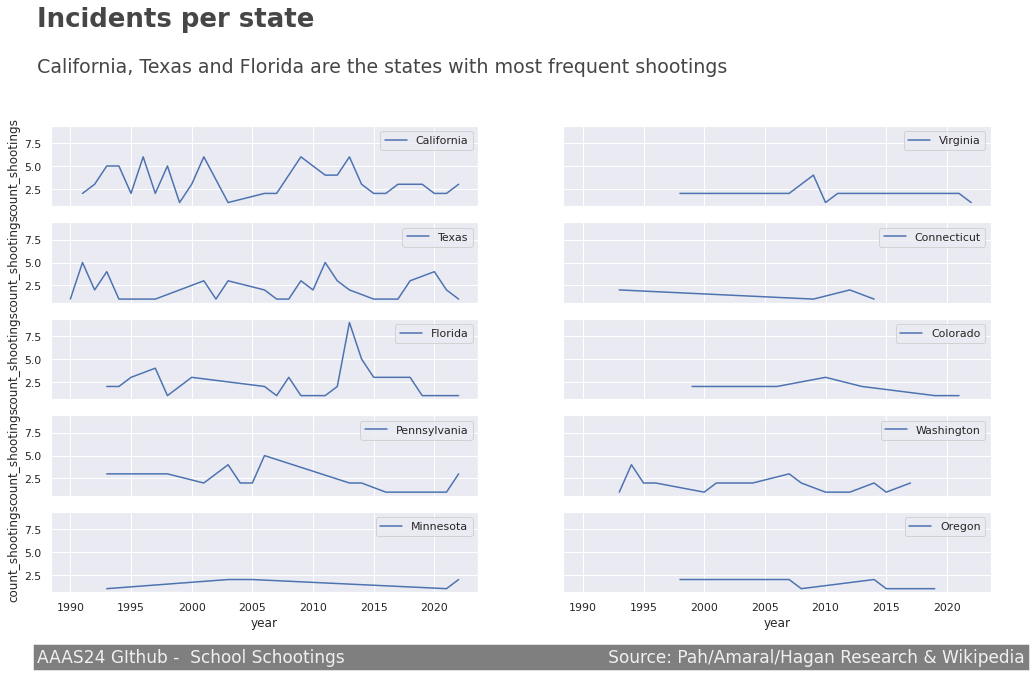

In [175]:
## Incidents per state
title='Incidents per state'
subtitle='California, Texas and Florida are the states with most frequent shootings'
text_x=25

data=(
    df.copy()
    [df.state.isin(top_states)]
    .loc[:,['year','state']]
    .groupby(['state', 'year'])
    .agg({'year': "count"} )
    .rename(columns={"year":"count_shootings"})
    .reset_index()
)
data
# grid
num_states=round(len(top_states))
cols=2
rows=int(np.ceil(num_states/cols))
fix, axes = plt.subplots(rows, cols, figsize=(15,8),sharex=True, sharey=True)
axes = axes.reshape(cols * rows)
for i, k in enumerate(range(0, len(top_states)), 0):
  ax = axes[i]
  state_i=top_states[i]
  state_data=data[data.state==state_i].drop('state', axis=1)
  sns.lineplot(data=state_data, x='year', y='count_shootings', ax=ax, label=state_i)

###Title & Subtitle
x=+1945
y=(7.5*5)+(2*5)
plt.text(x=x, y=y+15, 
              s=title, 
              fontsize=26, weight='bold', alpha=.85
              )
plt.text(x=x, y=y+10, 
              s=subtitle, 
              fontsize=19, alpha=.85
              )

##Footer #1
num_spaces=" ".join(" "*int(text_x))
plt.text(x=x, y=-7, 
              s=footer_left+num_spaces+footer_right,
              fontsize=17, color="#f0f0f0",
              bbox=dict(facecolor="black", alpha=0.5)
              )
plt.show()

## Fatalities per state (Top 10 states with highest)

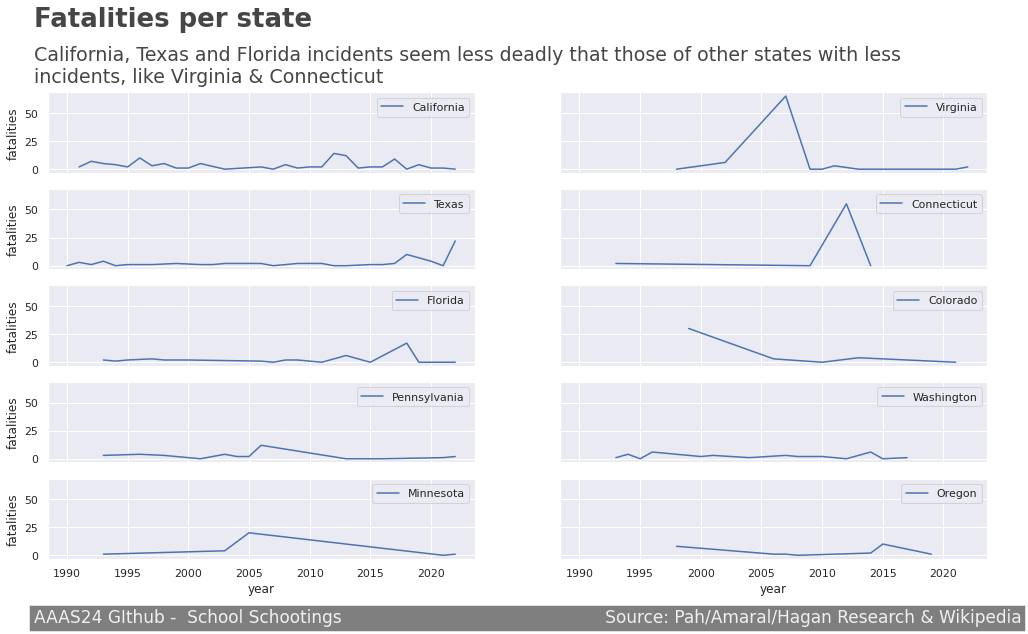

In [176]:
title='Fatalities per state'
subtitle='California, Texas and Florida incidents seem less deadly that those of other states with less \nincidents, like Virginia & Connecticut'
text_x=25

data=(
    df.copy()
    .loc[:,['year','state', 'fatalities']]
    [df.state.isin(top_states)]
    .groupby(['state','year']).sum()
    .reset_index()
)
# grid
num_states=round(len(top_states))
cols=2
rows=int(np.ceil(num_states/cols))
fix, axes = plt.subplots(rows, cols, figsize=(15,8),sharex=True, sharey=True)
axes = axes.reshape(cols * rows)
for i, k in enumerate(range(0, len(top_states)), 0):
  ax = axes[i]
  state_i=top_states[i]
  state_data=data[data.state==state_i].drop('state', axis=1)
  sns.lineplot(data=state_data, x='year', y='fatalities', ax=ax, label=state_i)
  plt.xlabel=(None)

###Title & Subtitle
x=+1945
y=(52*5)+(2*5)
plt.text(x=x, y=y+200, 
              s=title, 
              fontsize=26, weight='bold', alpha=.85
              )
plt.text(x=x, y=y+150, 
              s=subtitle, 
              fontsize=19, alpha=.85
              )

##Footer #1
num_spaces=" ".join(" "*int(text_x))
plt.text(x=x, y=-60, 
              s=footer_left+num_spaces+footer_right,
              fontsize=17, color="#f0f0f0",
              bbox=dict(facecolor="black", alpha=0.5)
              )
plt.show()



# ML: Word processing

In [177]:
## NPL to Desc:  Wordcloud of all data
# libraries for NLP
import nltk
nltk.download('omw-1.4')
from nltk import FreqDist
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer


# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    




[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# clean text data

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

#define original data
dirty = (
    df.copy()
    ['desc']
    .reset_index()
    .dropna()
)

##clean data
content_clean=dirty.desc.apply(lambda x: clean_text(x))

##graphic wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
 
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))
 
    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)
 
    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(content_clean)